In [41]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
data_dir = '~/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [43]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [44]:
train['price']

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

In [45]:
test.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


## EDA & FE

In [46]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [47]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

In [48]:
print(train.shape, test.shape)

(15035, 21) (6468, 20)


train과 test의 정보와 크기를 확인했을 때 모든 feature에는 결측치가 없음을 확인할 수 있다.

In [49]:
train['date'] = train['date'].apply(lambda i:i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i:i[:6]).astype(int)

집을 구매한 날짜에 대한 정보가 있는 date가 object형태로 불필요한 정보까지 담고있어 이를 정리해줬다.

In [50]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

def log_scaling(data, skew_columns):
    for c in skew_columns:
        data[c] = np.log1p(data[c].values)
    return data

log_scaling(train, skew_columns)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,1.386294,1.00,7.074117,8.639588,1.0,0,0,...,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,1,201502,180000.0,1.098612,1.00,6.647688,9.210440,1.0,0,0,...,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,2,201502,510000.0,1.386294,2.00,7.427144,8.997271,1.0,0,0,...,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,3,201406,257500.0,1.386294,2.25,7.447751,8.827615,2.0,0,0,...,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,4,201501,291850.0,1.386294,1.50,6.966967,9.181118,1.0,0,0,...,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118


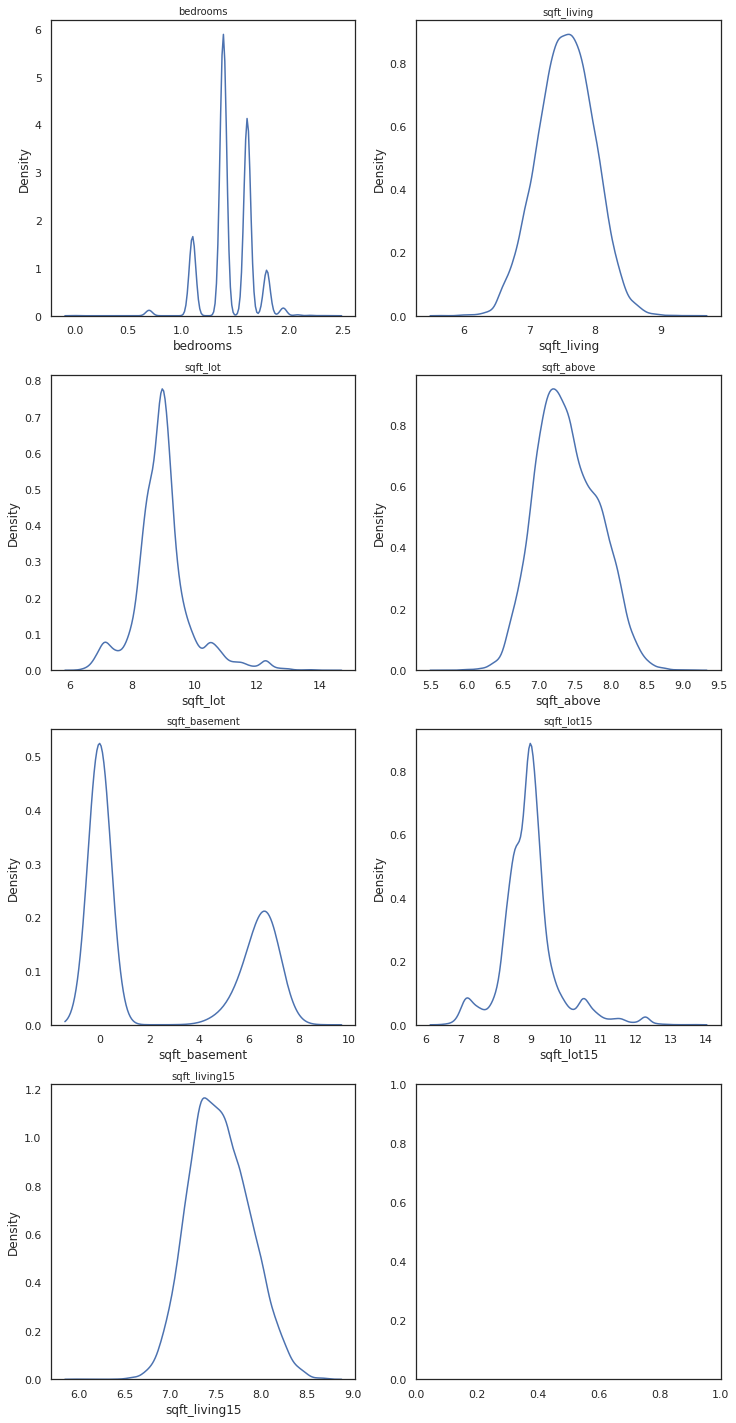

In [51]:
fig, ax = plt.subplots(4, 2, figsize=(12, 25))

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 0
columns = skew_columns
for row in range(4):
    for col in range(2):
        sns.kdeplot(data=train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=10)
        count += 1
        if count == 7 :
            break

새로운 피처 추가
- 전체 방의 개수 : bedroom + bathroom
- 재건축 여부 : 재건축년도-건축년도 = 0(안함) 1(함)

In [52]:
for df in [train,test]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)

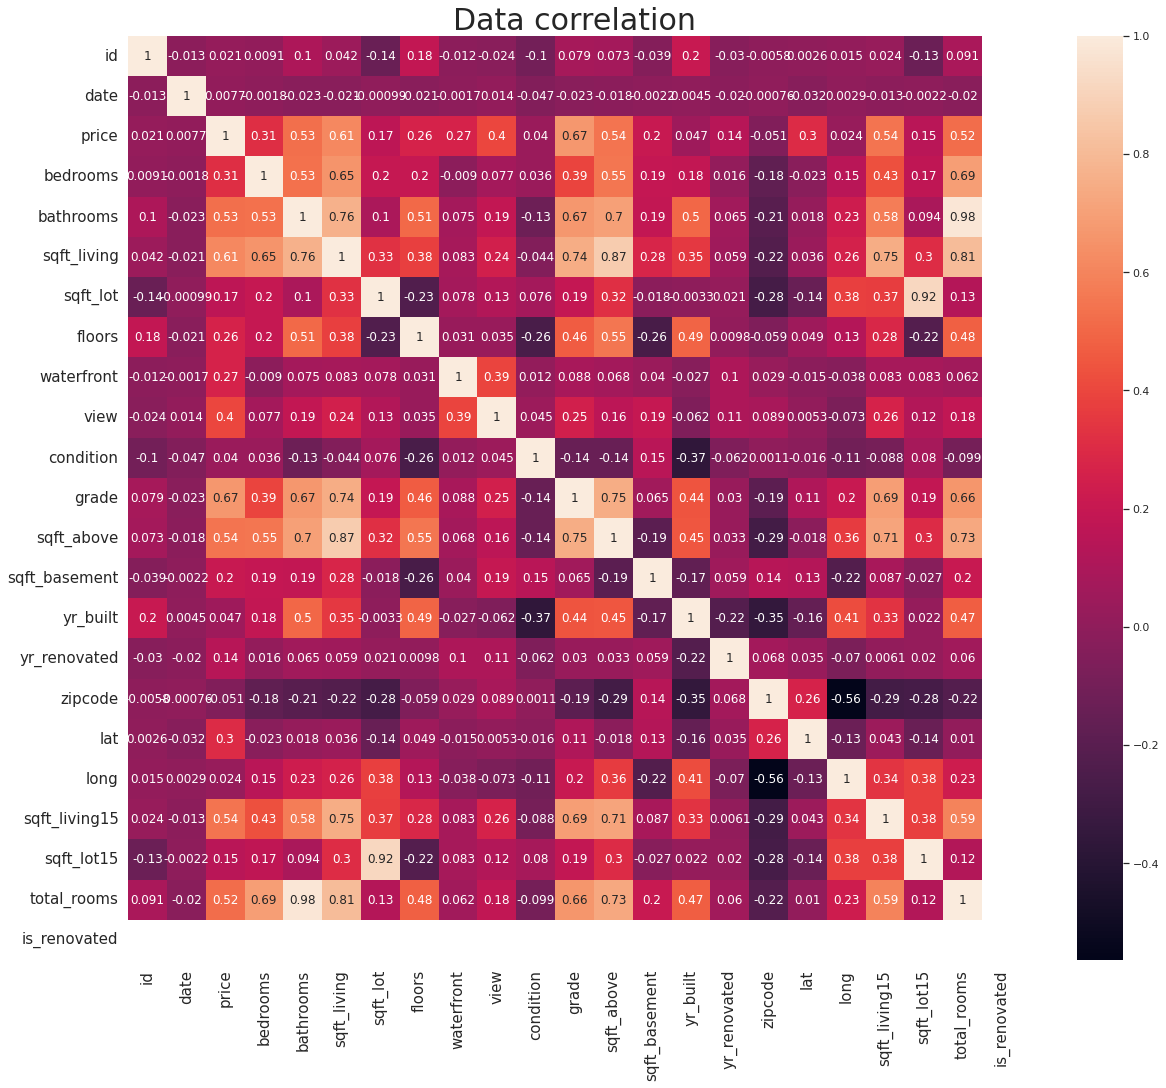

In [53]:
sns.set(style="white")

cor = train.corr()

f, ax = plt.subplots(figsize=(20, 17))
sns.heatmap(cor, annot=True)

plt.title('Data correlation', size=30)
ax.set_xticklabels(list(train.columns), size=15, rotation=90)
ax.set_yticklabels(list(train.columns), size=15, rotation=0);

대부분의 feature값은 수치형 데이터로 상관계수를 확인해보았다.
- 예측해야할 값인 price와의 상관계수를 집중적으로 살펴보았을 때 sqft_living, grade, sqft_above가 높은 양의 상관관계를 갖음을 알 수 있다.
- id,date 경우 제거할 feature

<AxesSubplot:xlabel='price', ylabel='Density'>

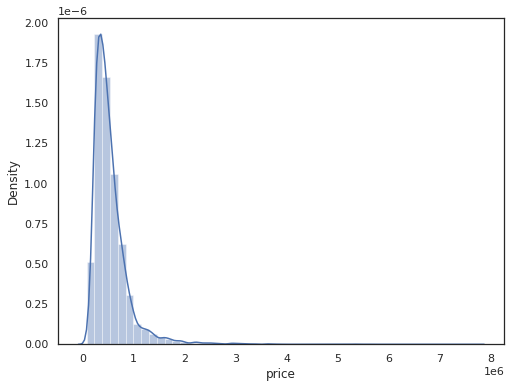

In [54]:
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['price'])

<AxesSubplot:xlabel='price', ylabel='Density'>

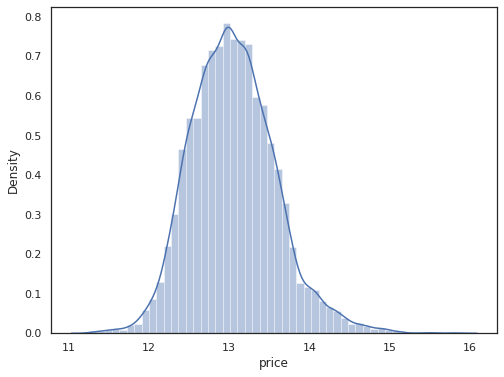

In [55]:
train['price'] = np.log1p(train['price'])

f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(train['price'])

예측하고자하는 target변수인 price의 분포를 살펴보았을 때 왼쪽으로 치우친 경향을 볼 수 있다.
회귀 분석의 경우 데이터의 분포가 정규분포를 따르는 것이 예측에 효율적이기 때문에 log변환을 통해 데이터의 분포를 정규분포로 바꿔줘야한다.

In [56]:
y = train['price']
del train['price']

train_len=len(train)
data = pd.concat((train, test), axis=0)

In [57]:
data.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'total_rooms', 'is_renovated'],
      dtype='object')

In [58]:
# 필요없는 feature 삭제
columns = ['grade', 'sqft_living', 'sqft_living15', 'sqft_above', 'bathrooms','lat', 'bedrooms', 'floors', 'view', 'sqft_basement']

data = data[columns]
data.head()

,grade,sqft_living,sqft_living15,sqft_above,bathrooms,lat,bedrooms,floors,view,sqft_basement
0,7,7.074117,7.201171,7.074117,1.00,47.5112,1.386294,1.0,0,0.0
1,6,6.647688,7.908755,6.647688,1.00,47.7379,1.098612,1.0,0,0.0
2,8,7.427144,7.496097,7.427144,2.00,47.6168,1.386294,1.0,0,0.0
3,7,7.447751,7.713785,7.447751,2.25,47.3097,1.386294,2.0,0,0.0
4,7,6.966967,7.409136,6.966967,1.50,47.4095,1.386294,1.0,0,0.0


In [59]:
test = data.iloc[train_len:, :]
train = data.iloc[:train_len, :]

In [60]:
y #로그변환이 된 상태

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

### 모델 학습

In [21]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [22]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [24]:
y_pred = AveragingBlending(models, train, y, test)
print(len(y_pred))
y_pred

6468


array([13.51303052, 13.51261829, 14.87985307, ..., 14.01375371,
       13.80708995, 13.88260289])

### 모델 튜닝

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [39]:
random_state=2020       
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor   

xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [xgboost, lightgbm, rdforest]

In [27]:
def get_scores(models, train, y):
    df = {}
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__
        # train, test 데이터셋 분리
        # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, shuffle=True, random_state=34) 

        # 모델 학습
        model.fit(X_train, y_train)
        # 예측
        y_pred = model.predict(X_test)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_pred, y_test)
    
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

In [29]:
# 그리드 서치
from sklearn.model_selection import GridSearchCV

#rdforest
param_grid3 = {
    'n_estimators': [50,75,100],
    'max_depth': [2,6,8,10],
    'min_samples_split': [2, 3, 4],
}

#lgbm
param_grid2 = {
    'n_estimators': [50,75,100],
    'max_depth': [2,6,8,10],
    'learning_rate':[0.05,0.075,0.1]
}

#xgboost
param_grid1 = {
    'n_estimators': [50,75,100],
    'max_depth': [2,6,8,10],
    'eta':[0.05,0.075,0.1]
}

In [30]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [31]:
model = models[0]
my_GridSearch(model, train, y,param_grid1,verbose=2,n_jobs=5)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

,eta,max_depth,n_estimators,score,RMSLE
29,0.100,6,100,-0.043843,0.209386
20,0.075,8,100,-0.043935,0.209607
23,0.075,10,100,-0.043941,0.209622
32,0.100,8,100,-0.044002,0.209767
34,0.100,10,75,-0.044052,0.209886
17,0.075,6,100,-0.044056,0.209896
31,0.100,8,75,-0.044107,0.210016
35,0.100,10,100,-0.044126,0.210061
28,0.100,6,75,-0.044212,0.210267
22,0.075,10,75,-0.045592,0.213523


[CV] END .............eta=0.05, max_depth=2, n_estimators=50; total time=   4.7s
[CV] END .............eta=0.05, max_depth=2, n_estimators=75; total time=   5.9s
[CV] END ............eta=0.05, max_depth=2, n_estimators=100; total time=  11.6s
[CV] END .............eta=0.05, max_depth=6, n_estimators=50; total time=  13.8s
[CV] END .............eta=0.05, max_depth=6, n_estimators=75; total time=  21.7s
[CV] END ............eta=0.05, max_depth=6, n_estimators=100; total time=  36.2s
[CV] END .............eta=0.05, max_depth=8, n_estimators=50; total time=  14.8s
[CV] END .............eta=0.05, max_depth=8, n_estimators=75; total time=  22.7s
[CV] END ............eta=0.05, max_depth=8, n_estimators=100; total time=  36.9s
[CV] END ............eta=0.05, max_depth=10, n_estimators=50; total time=  11.1s
[CV] END ............eta=0.05, max_depth=10, n_estimators=50; total time=  11.5s
[CV] END ............eta=0.05, max_depth=10, n_estimators=75; total time=  28.8s
[CV] END ...........eta=0.05

In [33]:
model = models[1]
my_GridSearch(model, train, y,param_grid2,verbose=2,n_jobs=5)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
31,0.100,8,75,-0.043199,0.207844
23,0.075,10,100,-0.043217,0.207888
32,0.100,8,100,-0.043223,0.207901
35,0.100,10,100,-0.043249,0.207963
34,0.100,10,75,-0.043276,0.208028
20,0.075,8,100,-0.043327,0.208151
22,0.075,10,75,-0.043411,0.208354
17,0.075,6,100,-0.043439,0.208419
19,0.075,8,75,-0.043483,0.208527
11,0.050,10,100,-0.043589,0.208780


# 최적의 파라미터를 적용한 앙상블 모델 gboost,xgboost, lightgmb,rdforest

In [ ]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)


y_pred = AveragingBlending(models, train, y, test)
print(len(y_pred))
y_pred

In [61]:
xgboost_b = XGBRegressor(max_depth=6,n_estimators=100, eta=0.075 ,random_state=random_state)
lightgbm_b = LGBMRegressor(max_depth=8,n_estimators=75,learning_rate=0.1 ,random_state=random_state)
rdforest_b = RandomForestRegressor(max_depth=10,n_estimators=100,min_samples_split=4,random_state=random_state)

In [62]:
models = [{'model':xgboost_b, 'name':'XGBoost'}, {'model':lightgbm_b, 'name':'LightGBM'}, {'model':rdforest_b, 'name':'RandomForest'}]
models_list = [xgboost_b, lightgbm_b, rdforest_b]

In [64]:
prediction = AveragingBlending(models, train, y, test)
print(prediction)
prediction = np.expm1(prediction)
print(prediction)

[13.40977318 13.36224653 14.77758469 ... 13.91445031 13.7100053
 13.70753565]
[ 666484.17935386  635549.30608431 2617118.10220424 ... 1103998.78849375
  899868.73799632  897649.12087988]


In [65]:
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = prediction
submission_csv_path = 'submission_{}.csv'.format( 'p2')
submission.to_csv(submission_csv_path, index = False)

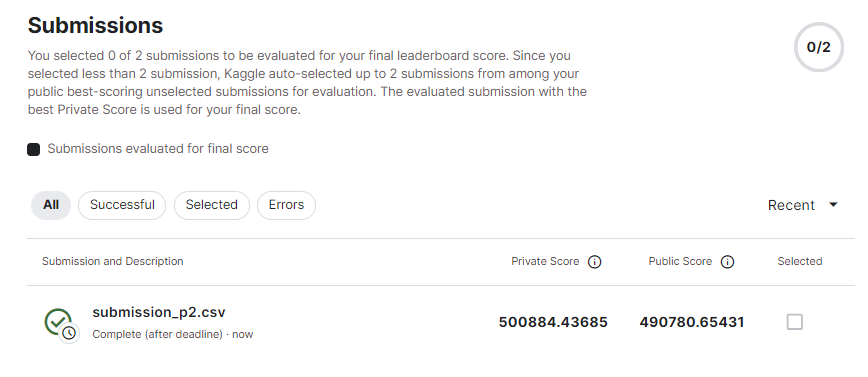